In [20]:
import numpy as np

import pickle
from feeder import tools

import torch
import torch.nn as nn

from net import st_gcn

In [21]:
class Feeder(torch.utils.data.Dataset):
    """ Feeder for skeleton-based action recognition
    Arguments:
        data_path: the path to '.npy' data, the shape of data should be (N, C, T, V, M)
        label_path: the path to label
        random_choose: If true, randomly choose a portion of the input sequence
        random_shift: If true, randomly pad zeros at the begining or end of sequence
        window_size: The length of the output sequence
        normalization: If true, normalize input sequence
        debug: If true, only use the first 100 samples
    """

    def __init__(self,
                 data_path,
                 label_path,
                 random_choose=False,
                 random_move=False,
                 window_size=-1,
                 debug=False,
                 mmap=True):
        self.debug = debug
        self.data_path = data_path
        self.label_path = label_path
        self.random_choose = random_choose
        self.random_move = random_move
        self.window_size = window_size

        self.load_data(mmap)

    def load_data(self, mmap):
        # data: N C V T M

        # load label
        with open(self.label_path, 'rb') as f:
            self.sample_name, self.label = pickle.load(f)

        # load data
        if mmap:
            self.data = np.load(self.data_path, mmap_mode='r')
        else:
            self.data = np.load(self.data_path)

        if self.debug:
            self.label = self.label[0:100]
            self.data = self.data[0:100]
            self.sample_name = self.sample_name[0:100]

        self.N, self.C, self.T, self.V, self.M = self.data.shape

    def __len__(self):
        return len(self.label)

    def __getitem__(self, index):
        # get data
        data_numpy = np.array(self.data[index])
        label = self.label[index]

        # processing
        if self.random_choose:
            data_numpy = tools.random_choose(data_numpy, self.window_size)
        elif self.window_size > 0:
            data_numpy = tools.auto_pading(data_numpy, self.window_size)
        if self.random_move:
            data_numpy = tools.random_move(data_numpy)

        return data_numpy, label

In [22]:
label_name_path = './resource/kinetics_skeleton/label_name.txt'
with open(label_name_path) as f:
    label_name = f.readlines()
    label_name = [line.rstrip() for line in label_name]

In [23]:
dev = "cuda:0"

label_name_path = './resource/kinetics_skeleton/label_name.txt'
with open(label_name_path) as f:
    label_name = f.readlines()
    label_name = [line.rstrip() for line in label_name]

data_path = "./data/NTURGBD-sharing/xsub/val_data.npy"
label_path = "./data/NTURGBD-sharing/xsub/val_label.pkl"
dset = Feeder(data_path, label_path)

data_loader = torch.utils.data.DataLoader(
    dataset=dset,
    batch_size=64,
    shuffle=False)

graph_args = {'layout': 'ntu-rgb+d', 'strategy': 'spatial'}

model = st_gcn.Model(in_channels=3, num_class=60,
                     graph_args=graph_args, edge_importance_weighting=True)
weights = torch.load("./work_dir/recognition/ntu-xsub/ST_GCN/epoch50_model.pt")
model.load_state_dict(weights)
model.eval()

model = model.to(dev)

loss_value = []
result_frag = []
label_frag = []

In [24]:
output_all = []
voting_label_all = []
label_all = []

In [25]:
for num in range(10):
    data, label = data_loader.__iter__().__next__()
    data = data.float().to(dev)
    label = label.long().to(dev)

    with torch.no_grad():
        output_batch, feature_batch = model.extract_feature(data)     

        for i in range (len(label)):
            output = output_batch[i]
            feature = feature_batch[i]
            intensity = (feature * feature).sum(dim=0) ** 0.5
            intensity = intensity.cpu().detach().numpy()

            # classification result of the full sequence
            voting_label = output.sum(dim=3).sum(
                dim=2).sum(dim=1).argmax(dim=0)
            voting_label_name = label_name[voting_label]
            print("voting_label_name is ", voting_label_name)

            real_label_name = label_name[label[i]]
            print("real label is", real_label_name)

            output_all.append(output.data.cpu().numpy())
            voting_label_all.append(voting_label.data.cpu().numpy())
            label_all.append(label[i].data.cpu().numpy())

voting_label_name is  answering questions
real label is auctioning
voting_label_name is  auctioning
real label is auctioning
voting_label_name is  bobsledding
real label is baking cookies
voting_label_name is  bookbinding
real label is baking cookies
voting_label_name is  auctioning
real label is auctioning
voting_label_name is  bobsledding
real label is baking cookies
voting_label_name is  cheerleading
real label is cheerleading
voting_label_name is  changing oil
real label is changing oil
voting_label_name is  cheerleading
real label is cheerleading
voting_label_name is  baking cookies
real label is baking cookies
voting_label_name is  breading or breadcrumbing
real label is auctioning
voting_label_name is  changing oil
real label is changing oil
voting_label_name is  bookbinding
real label is baking cookies
voting_label_name is  baking cookies
real label is baking cookies
voting_label_name is  changing oil
real label is changing oil
voting_label_name is  changing oil
real label is c

voting_label_name is  answering questions
real label is auctioning
voting_label_name is  auctioning
real label is auctioning
voting_label_name is  bobsledding
real label is baking cookies
voting_label_name is  bookbinding
real label is baking cookies
voting_label_name is  auctioning
real label is auctioning
voting_label_name is  bobsledding
real label is baking cookies
voting_label_name is  cheerleading
real label is cheerleading
voting_label_name is  changing oil
real label is changing oil
voting_label_name is  cheerleading
real label is cheerleading
voting_label_name is  baking cookies
real label is baking cookies
voting_label_name is  breading or breadcrumbing
real label is auctioning
voting_label_name is  changing oil
real label is changing oil
voting_label_name is  bookbinding
real label is baking cookies
voting_label_name is  baking cookies
real label is baking cookies
voting_label_name is  changing oil
real label is changing oil
voting_label_name is  changing oil
real label is c

voting_label_name is  answering questions
real label is auctioning
voting_label_name is  auctioning
real label is auctioning
voting_label_name is  bobsledding
real label is baking cookies
voting_label_name is  bookbinding
real label is baking cookies
voting_label_name is  auctioning
real label is auctioning
voting_label_name is  bobsledding
real label is baking cookies
voting_label_name is  cheerleading
real label is cheerleading
voting_label_name is  changing oil
real label is changing oil
voting_label_name is  cheerleading
real label is cheerleading
voting_label_name is  baking cookies
real label is baking cookies
voting_label_name is  breading or breadcrumbing
real label is auctioning
voting_label_name is  changing oil
real label is changing oil
voting_label_name is  bookbinding
real label is baking cookies
voting_label_name is  baking cookies
real label is baking cookies
voting_label_name is  changing oil
real label is changing oil
voting_label_name is  changing oil
real label is c

voting_label_name is  answering questions
real label is auctioning
voting_label_name is  auctioning
real label is auctioning
voting_label_name is  bobsledding
real label is baking cookies
voting_label_name is  bookbinding
real label is baking cookies
voting_label_name is  auctioning
real label is auctioning
voting_label_name is  bobsledding
real label is baking cookies
voting_label_name is  cheerleading
real label is cheerleading
voting_label_name is  changing oil
real label is changing oil
voting_label_name is  cheerleading
real label is cheerleading
voting_label_name is  baking cookies
real label is baking cookies
voting_label_name is  breading or breadcrumbing
real label is auctioning
voting_label_name is  changing oil
real label is changing oil
voting_label_name is  bookbinding
real label is baking cookies
voting_label_name is  baking cookies
real label is baking cookies
voting_label_name is  changing oil
real label is changing oil
voting_label_name is  changing oil
real label is c

In [26]:
np.shape(output_all)

(640, 60, 75, 25, 2)

In [27]:
np.shape(label_all)

(640,)

In [28]:
def resize(x):
    N, C, T, V, M = x.size()
    x = x.permute(0, 3, 1, 2, 4).contiguous()
    x = x.view(N, V * C * T, M)
    return x

In [29]:
tsne_data = resize(torch.tensor(output_all))
tsne_data.shape

torch.Size([640, 112500, 2])

In [30]:
data = tsne_data[:, :, 0]
label = np.array(label_all)
print(data.shape)
print(label.shape)

torch.Size([640, 112500])
(640,)


In [31]:
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.manifold import TSNE

def plot_embedding_2D(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)
    fig = plt.figure()
    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(label[i]),
                 color=plt.cm.Set1(label[i]),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    return fig
def plot_embedding_3D(data,label,title): 
    x_min, x_max = np.min(data,axis=0), np.max(data,axis=0) 
    data = (data- x_min) / (x_max - x_min) 
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d') 
    for i in range(data.shape[0]): 
        ax.text(data[i, 0], data[i, 1], data[i,2],str(label[i]), color=plt.cm.Set1(label[i]),fontdict={'weight': 'bold', 'size': 9}) 
    return fig

Begining......
Finished......


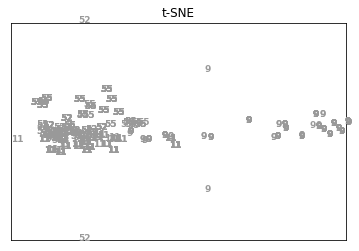

In [32]:
print('Begining......') #时间会较长，所有处理完毕后给出finished提示
tsne_2D = TSNE(n_components=2, init='pca', random_state=0) #调用TSNE
result_2D = tsne_2D.fit_transform(data)
print('Finished......')
#调用上面的两个函数进行可视化
fig1 = plot_embedding_2D(result_2D, label,'t-SNE')
plt.show(fig1)

In [33]:
result_2D.shape

(640, 2)

In [34]:
result_2D[:10,]

array([[  -71.77476,  -790.1626 ],
       [ 7147.18   ,   750.3396 ],
       [-1615.4819 , -1372.5497 ],
       [ -794.88293, -4314.477  ],
       [  659.1966 , -2162.005  ],
       [ 1350.4888 , -1962.0548 ],
       [  228.00447,   869.6166 ],
       [-1276.2404 ,   344.4897 ],
       [-1063.403  ,  7992.7993 ],
       [-1084.1252 , -3023.8694 ]], dtype=float32)

In [35]:
np.unique(label)

array([ 9, 11, 52, 55])